---
title: "Análisis de proyección cambios componentes"
subtitle: "DANTOTSU"
author: "Departamento Confiabilidad"
date: today
---

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import dagster as dg

from kdags.definitions import *
from kdags.readr import *

context = dg.build_asset_context()
from kdags.assets.components.component_changeouts.assets import *


dl = DataLake(context)
msgraph = MSGraph(context)
from kdags.assets.docs.io_catalog import *
from kdags.config.catalog_loader import DATA_CATALOG
from datetime import datetime
from theme_komatsu import *
from great_tables import GT, md
from component_constants import *
from datetime import timedelta

# Activos de datos

In [2]:
component_df = MasterData.components()
equipments = MasterData.equipments()
positions_df = MasterData.positions()
pcp_repair_costs_df = dl.read_tibble(DATA_CATALOG["pcp_repair_costs"]["raw_path"])
gfa_ovh_rates_df = (
    dl.read_tibble(DATA_CATALOG["gfa_overhaul_rates"]["raw_path"])
    .select(
        [
            "site_name",
            "model_name",
            "component_name",
            "subcomponent_name",
            "mtbo",
            "gfa_overhaul_rate",
        ]
    )
    .drop_nulls("component_name")
).with_columns(gfa_overhaul_rate=pl.col("gfa_overhaul_rate").round(0).cast(pl.Int64))

cc_proj_df = pl.concat(
    [
        pl.DataFrame(component_data_raw_960E)
        .with_columns(model_name=pl.lit("960E"), site_name=pl.lit("MEL"))
        .with_columns(pl.col("month").str.to_date("%Y-%m-%d")),
        pl.DataFrame(component_data_raw_930E)
        .with_columns(model_name=pl.lit("930E-4"), site_name=pl.lit("MEL"))
        .with_columns(pl.col("month").str.to_date("%Y-%m-%d")),
        component_data_raw_spence.with_columns(
            model_name=pl.lit("980E-5"), site_name=pl.lit("SPENCE")
        ),
    ],
    how="diagonal_relaxed",
).rename({"month": "month_date"})


# Dejando lista la proyección componentes Haydee
# Revisarsi corresponde promediar el módulo potencia
agg_gfa = gfa_ovh_rates_df.group_by(
    ["site_name", "model_name", "component_name", "mtbo"]
).agg(gfa_overhaul_rate=pl.col("gfa_overhaul_rate").sum())
cc_proj_df = (
    cc_proj_df.join(
        agg_gfa,
        how="left",
        on=["model_name", "site_name", "component_name"],
    )
    .join(
        pcp_repair_costs_df.join(
            component_df.select(
                ["subcomponent_tag", "component_name", "subcomponent_name"]
            ),
            how="left",
            on=["subcomponent_tag"],
        )
        .group_by(["site_name", "model_name", "component_name"])
        .agg(mean_repair_cost=pl.col("mean_repair_cost").sum()),
        how="left",
        on=["site_name", "model_name", "component_name"],
    )
    .with_columns(proj_component_hours=pl.col("mtbo") * 1.05)
    .pipe(calculate_prorrata_sale)
    .with_columns(
        site_sale=pl.col("prorrata_sale") * pl.col("cc_amount"),
        site_repair_cost=pl.col("mean_repair_cost") * pl.col("cc_amount"),
    )
)

# Procesamiento del PAM
file_content = dl.read_bytes("az://bhp-raw-data/PLANNING/PAM/PPTO_FY2025.xlsx")
pam_df = pd.read_excel(
    BytesIO(file_content), skiprows=5, sheet_name="PAM Gnral", usecols="A:AC", dtype=str
)

pam_df = (
    pl.from_pandas(pam_df)
    .with_row_index("row_idx")  # Add this line
    .select(
        [
            "row_idx",
            "Cod Comp RMCare",
            "Faena",
            "Modelo",
            "Cod Pos RMCare",
            "Fecha de Cambio",
            "Hrs Proy de cambio",
            "Costo",
            "Cantidad",
            "%USO",
            "NRO INT.",
            "Motivo de Cambio",
        ]
    )
    .rename(
        {
            "Cod Comp RMCare": "subcomponent_tag",
            "Cod Pos RMCare": "position_tag",
            "Hrs Proy de cambio": "proj_component_hours",
            "Fecha de Cambio": "proj_changeout_date",
            "Faena": "site_name",
            "Modelo": "model_name",
            "Costo": "pam_repair_cost",
            "Cantidad": "proj_cc_amount",
            "%USO": "component_usage",
            "NRO INT.": "pam_equipment_name",
            "Motivo de Cambio": "changeout_reason",
        }
    )
).with_columns(
    row_idx=pl.col("row_idx") + 6,
    proj_changeout_date=pl.col("proj_changeout_date").str.to_date(
        "%Y-%m-%d %H:%M:%S", strict=False
    ),
    proj_component_hours=pl.col("proj_component_hours").cast(
        pl.Float64, strict=False
    ),  ##Revisar
    proj_cc_amount=pl.col("proj_cc_amount").cast(pl.Int64),
    pam_repair_cost=pl.col("pam_repair_cost").cast(pl.Float64),
    component_usage=pl.col("component_usage").cast(pl.Float64, strict=False).round(3),
    model_name=pl.col("model_name").replace(
        {
            "960E-1": "960E",
            "960E-2": "960E",
        }
    ),
    site_name=pl.col("site_name").replace(
        {
            "Spence": "SPENCE",
            "Escondida": "MEL",
        }
    ),
    changeout_reason=pl.col("changeout_reason").fill_null(pl.lit("unknown")),
)
pam_df = pam_df.filter(pl.col("model_name").is_in(["930E-4", "960E", "980E-5"]))
pam_df = pam_df.filter(pl.col("site_name").is_in(["SPENCE", "MEL"]))
pam_df = pam_df.join(
    component_df.select(["subcomponent_tag", "component_name", "subcomponent_name"]),
    on="subcomponent_tag",
    how="left",
).join(
    positions_df.select(["position_name", "position_tag"]),
    on="position_tag",
    how="left",
)

# Agregar costos medios PCP
pcp_merge_columns = ["site_name", "model_name", "subcomponent_tag"]
pam_df = (
    pam_df.join(
        pcp_repair_costs_df.select([*pcp_merge_columns, "mean_repair_cost", "tbo"]),
        on=pcp_merge_columns,
        how="left",
        validate="m:1",
    )
    .join(
        component_df.select(
            ["component_name", "subcomponent_name", "subcomponent_main"]
        ),
        how="left",
        on=["component_name", "subcomponent_name"],
    )
    .with_columns(
        proj_cc_amount=(pl.col("subcomponent_main") * 1).fill_null(0)
        * pl.col("proj_cc_amount")
    )
    .drop("subcomponent_main")
)


pam_df = pam_df.join(
    gfa_ovh_rates_df,
    how="left",
    on=["site_name", "model_name", "component_name", "subcomponent_name"],
).pipe(calculate_prorrata_sale)

2025-06-13 09:14:14 -0400 - dagster - INFO - system - Reading data from Azure path: az://bhp-raw-data/REFERENCE/pcp_repair_costs.xlsx
2025-06-13 09:14:15 -0400 - dagster - INFO - system - Successfully read data from: az://bhp-raw-data/REFERENCE/pcp_repair_costs.xlsx
2025-06-13 09:14:15 -0400 - dagster - INFO - system - Data shape: 45 rows, 11 columns
2025-06-13 09:14:15 -0400 - dagster - INFO - system - Reading data from Azure path: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
2025-06-13 09:14:15 -0400 - dagster - INFO - system - Successfully read data from: az://bhp-raw-data/REFERENCE/gfa_overhaul_rates.xlsx
2025-06-13 09:14:15 -0400 - dagster - INFO - system - Data shape: 26 rows, 7 columns


In [3]:
# Then join back to your main aggregation
sale_df = (
    pam_df.group_by(
        [
            "site_name",
            "model_name",
            "component_name",
            "position_name",
            "pam_equipment_name",
            "proj_changeout_date",
            "proj_component_hours",
            "changeout_reason",
        ],
        maintain_order=True,
    )
    .agg(
        proj_cc_amount=pl.col("proj_cc_amount").sum(),
        pam_repair_cost=pl.col("pam_repair_cost").sum(),
        prorrata_sale=pl.col("prorrata_sale").sum(),
    )
    .with_columns(proj_cc_amount=pl.col("proj_cc_amount").cast(pl.Int64))
)


sale_df = sale_df.filter(pl.col("proj_changeout_date").is_not_null())


monthly_df = (
    (
        sale_df.with_columns(
            pl.date(
                pl.col("proj_changeout_date").dt.year(),
                pl.col("proj_changeout_date").dt.month(),
                1,
            ).alias("month_date")
        )
        .group_by(["site_name", "model_name", "component_name", "month_date"])
        .agg(
            pam_repair_cost=pl.col("pam_repair_cost").sum(),
            prorrata_sale=pl.col("prorrata_sale").sum(),
            proj_cc_amount=pl.col("proj_cc_amount").sum(),
        )
        .sort(["site_name", "month_date"])
    )
    .join(
        cc_proj_df.with_columns(cc_amount=pl.col("cc_amount").fill_null(0))
        .group_by(["site_name", "model_name", "component_name", "month_date"])
        .agg(
            site_repair_cost=pl.col("site_repair_cost").sum(),
            site_sale=pl.col("site_sale").sum(),
            cc_amount=pl.col("cc_amount").sum(),
        ),
        how="full",
        coalesce=True,
        on=["site_name", "model_name", "component_name", "month_date"],
    )
    .with_columns(
        site_repair_cost=pl.col("site_repair_cost").round(0).cast(pl.Int64),
        site_sale=pl.col("site_sale").round(0).cast(pl.Int64),
        pam_repair_cost=pl.col("pam_repair_cost").round(0).cast(pl.Int64),
        prorrata_sale=pl.col("prorrata_sale").round(0).cast(pl.Int64),
        cc_amount=pl.col("cc_amount").fill_null(0),
    )
)
model_monthly_df = (
    monthly_df.group_by(
        [
            "site_name",
            "model_name",
            "month_date",
        ]
    )
    .agg(
        pl.sum(
            "pam_repair_cost",
            "prorrata_sale",
            "proj_cc_amount",
            "site_repair_cost",
            "site_sale",
        )
    )
    .sort(
        [
            "site_name",
            "model_name",
            "month_date",
        ]
    )
)
site_monthly_df = (
    monthly_df.group_by(
        [
            "site_name",
            "month_date",
        ]
    )
    .agg(
        pl.sum(
            "pam_repair_cost",
            "prorrata_sale",
            "proj_cc_amount",
            "site_repair_cost",
            "site_sale",
            "cc_amount",
        )
    )
    .join(
        bp_df,
        how="left",
        on=["site_name", "month_date"],
    )
).sort(
    [
        "site_name",
        "month_date",
    ]
)

In [4]:
columns_map = {
    "site_name": "Faena",
    "model_name": "Modelo",
    "component_name": "Componente",
    "subcomponent_name": "Subcomponente",
    "mtbo": "MTBO",
    "gfa_overhaul_rate": "Tarifa GFA",
    "otro": "otro",
    "tbo": "TBO",
    "mean_repair_cost": "Costo Medio Reparación",
    "proj_component_hours": "Hrs. Cambio PAM",
    "pam_repair_cost": "Costo PAM",
    "proj_cc_amount": "Cantidad Cambios Comp. PAM",
    "component_usage": "%USO PAM",
    "position_name": "Posición",
    "prorrata_sale": "Valor Venta",
    "cc_amount": "Cantidad Cambios Comp.",
    "month_date": "Fecha",
    "site_sale": "Venta Faena",
    "site_repair_cost": "Costo Reparación Faena",
}

#### Tabla final consolidada

Contiene un agregado por faena, modelo y componente de los valores venta costo y cantidades

[**monthly_summary**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/monthly_summary.xlsx)

Ejemplo de tabla, para datos completos favor usar link.

In [78]:
tibble_df = monthly_df.clone().rename(columns_map, strict=False)
msgraph.upload_tibble(tibble_df, "sp://KCHCLGR00058/___/PAM/monthly_summary.xlsx")
GT(tibble_df.head(3))

Faena,Modelo,Componente,Fecha,Costo PAM,Valor Venta,Cambio proyectado PAM,Costo Reparación Faena,Venta Faena,Cantidad Cambios Componentes
MEL,930E-4,conjunto_maza_suspension,2025-04-01,0,186512,2,None,None,0
MEL,960E,motor_traccion,2025-04-01,0,349986,1,503303,699972,2
MEL,930E-4,cilindro_direccion,2025-04-01,13300,0,2,None,None,0


#### Tarifas GFA

La siguiente tabla contiene la tarifa del GFA para efectos del cálculo de la prorrata:

[**gfa_overhaul_rates**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/gfa_ovh_rates.xlsx)

Ejemplo de tabla, para datos completos favor usar link.

In [28]:
tibble_df = gfa_ovh_rates_df.clone().rename(columns_map, strict=False)
msgraph.upload_tibble(tibble_df, "sp://KCHCLGR00058/___/PAM/gfa_ovh_rates.xlsx")
GT(tibble_df.head(3))

2025-06-12 20:48:27 -0400 - dagster - INFO - system - Writing 26 rows, 6 columns to sp://KCHCLGR00058/___/PAM/gfa_ovh_rates.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/PAM/gfa_ovh_rates.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/PAM/gfa_ovh_rates.xlsx:/')


Faena,Modelo,Componente,Subcomponente,MTBO,Tarifa GFA
MEL,960E,modulo_potencia,alternador_principal,16500,41320
MEL,960E,modulo_potencia,radiador,16500,10808
MEL,960E,modulo_potencia,subframe,16500,80142


#### Costos Medios de Reparación

Contiene los costos medios de reparación que se obtienen del sistema llamado "Programa Control de Presupuesto (PCP)"

[**pcp_repair_costs**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/pcp_repair_costs.xlsx)

Ejemplo de tabla, para datos completos favor usar link.


In [91]:
tibble_df = (
    pcp_repair_costs_df.clone()
    .rename(columns_map, strict=False)
    .drop(
        [
            "component_description",
            # "rmc_component_description",
            "subcomponent_tag",
            "First",
            "N/P",
        ]
    )
)
msgraph.upload_tibble(tibble_df, "sp://KCHCLGR00058/___/PAM/pcp_repair_costs.xlsx")
GT(tibble_df.head(3))

2025-06-12 21:35:11 -0400 - dagster - INFO - system - Writing 45 rows, 7 columns to sp://KCHCLGR00058/___/PAM/pcp_repair_costs.xlsx


Faena,Modelo,rmc_component_description,Costo Medio Reparación,TBO,Taller de reparación,Lugar de Reparación
MEL,930E-4,Radiador,25838.01,18000,Radiadores Gómez,Antofagasta
MEL,930E-4,Alternador Principal,48634.74,18000,KRCC,Antofagasta
MEL,930E-4,Soplador del Banco de Retardo (Blower),28011.636349705892,20000,KRCC,Antofagasta


#### PAM Valorizado

Contiene el programa de recambio de componentes o plan anual móvil (PAM) junto con cálculos adicionales para valorización de valor venta

[**pam**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/pam.xlsx)

Ejemplo de tabla, para datos completos favor usar link.

In [32]:
tibble_df = (
    pam_df.clone()
    .rename(columns_map, strict=False)
    .drop(
        [
            "subcomponent_tag",
            "position_tag",
        ]
    )
)

msgraph.upload_tibble(tibble_df, "sp://KCHCLGR00058/___/PAM/pam.xlsx")
GT(tibble_df.head(3))

2025-06-12 20:49:10 -0400 - dagster - INFO - system - Writing 933 rows, 17 columns to sp://KCHCLGR00058/___/PAM/pam.xlsx


Faena,Modelo,proj_changeout_date,Hrs. Cambio PAM,Costo PAM,Cambio proyectado PAM,%USO PAM,pam_equipment_name,changeout_reason,Componente,Subcomponente,Posición,Costo Medio Reparación,TBO,MTBO,Tarifa GFA,Valor Venta
SPENCE,980E-5,2026-02-01,14167.0,90812.7,0,0.675,CA48,unknown,modulo_potencia,subframe,unico,90812.7,21000,21000,83223,56144.0
SPENCE,980E-5,2026-02-01,14167.0,28804.05,0,0.675,CA48,unknown,modulo_potencia,radiador,unico,28804.05,21000,21000,12352,8333.0
SPENCE,980E-5,2026-02-01,14167.0,0.0,0,0.675,CA48,unknown,modulo_potencia,motor,unico,0.0,21000,None,None,0.0


#### Cambios de componentes faena

Contiene cambios de componentes en la faena valorizados.

[**site_changeouts**](https://globalkomatsu.sharepoint.com/sites/KCHCLGR00058/Shared%20Documents/___/PAM/site_changeouts.xlsx)

Ejemplo de tabla, para datos completos favor usar link.

In [33]:
tibble_df = cc_proj_df.clone().rename(columns_map, strict=False)

msgraph.upload_tibble(cc_proj_df, "sp://KCHCLGR00058/___/PAM/site_changeouts.xlsx")
GT(tibble_df.head(3))

2025-06-12 20:49:21 -0400 - dagster - INFO - system - Writing 165 rows, 13 columns to sp://KCHCLGR00058/___/PAM/site_changeouts.xlsx


Componente,Fecha,Cantidad Cambios Componentes,Modelo,Faena,Subcomponente,MTBO,Tarifa GFA,Costo Medio Reparación,Hrs. Cambio PAM,Valor Venta,Venta Faena,Costo Reparación Faena
blower_parrilla,2025-04-01,2,960E,MEL,blower_parrilla,20000,29105,28011.636349705892,21000.0,30560.0,61120.0,56023.272699411784
blower_parrilla,2025-05-01,1,960E,MEL,blower_parrilla,20000,29105,28011.636349705892,21000.0,30560.0,30560.0,28011.636349705892
blower_parrilla,2025-07-01,4,960E,MEL,blower_parrilla,20000,29105,28011.636349705892,21000.0,30560.0,122240.0,112046.54539882357


## Cantidades de Cambio

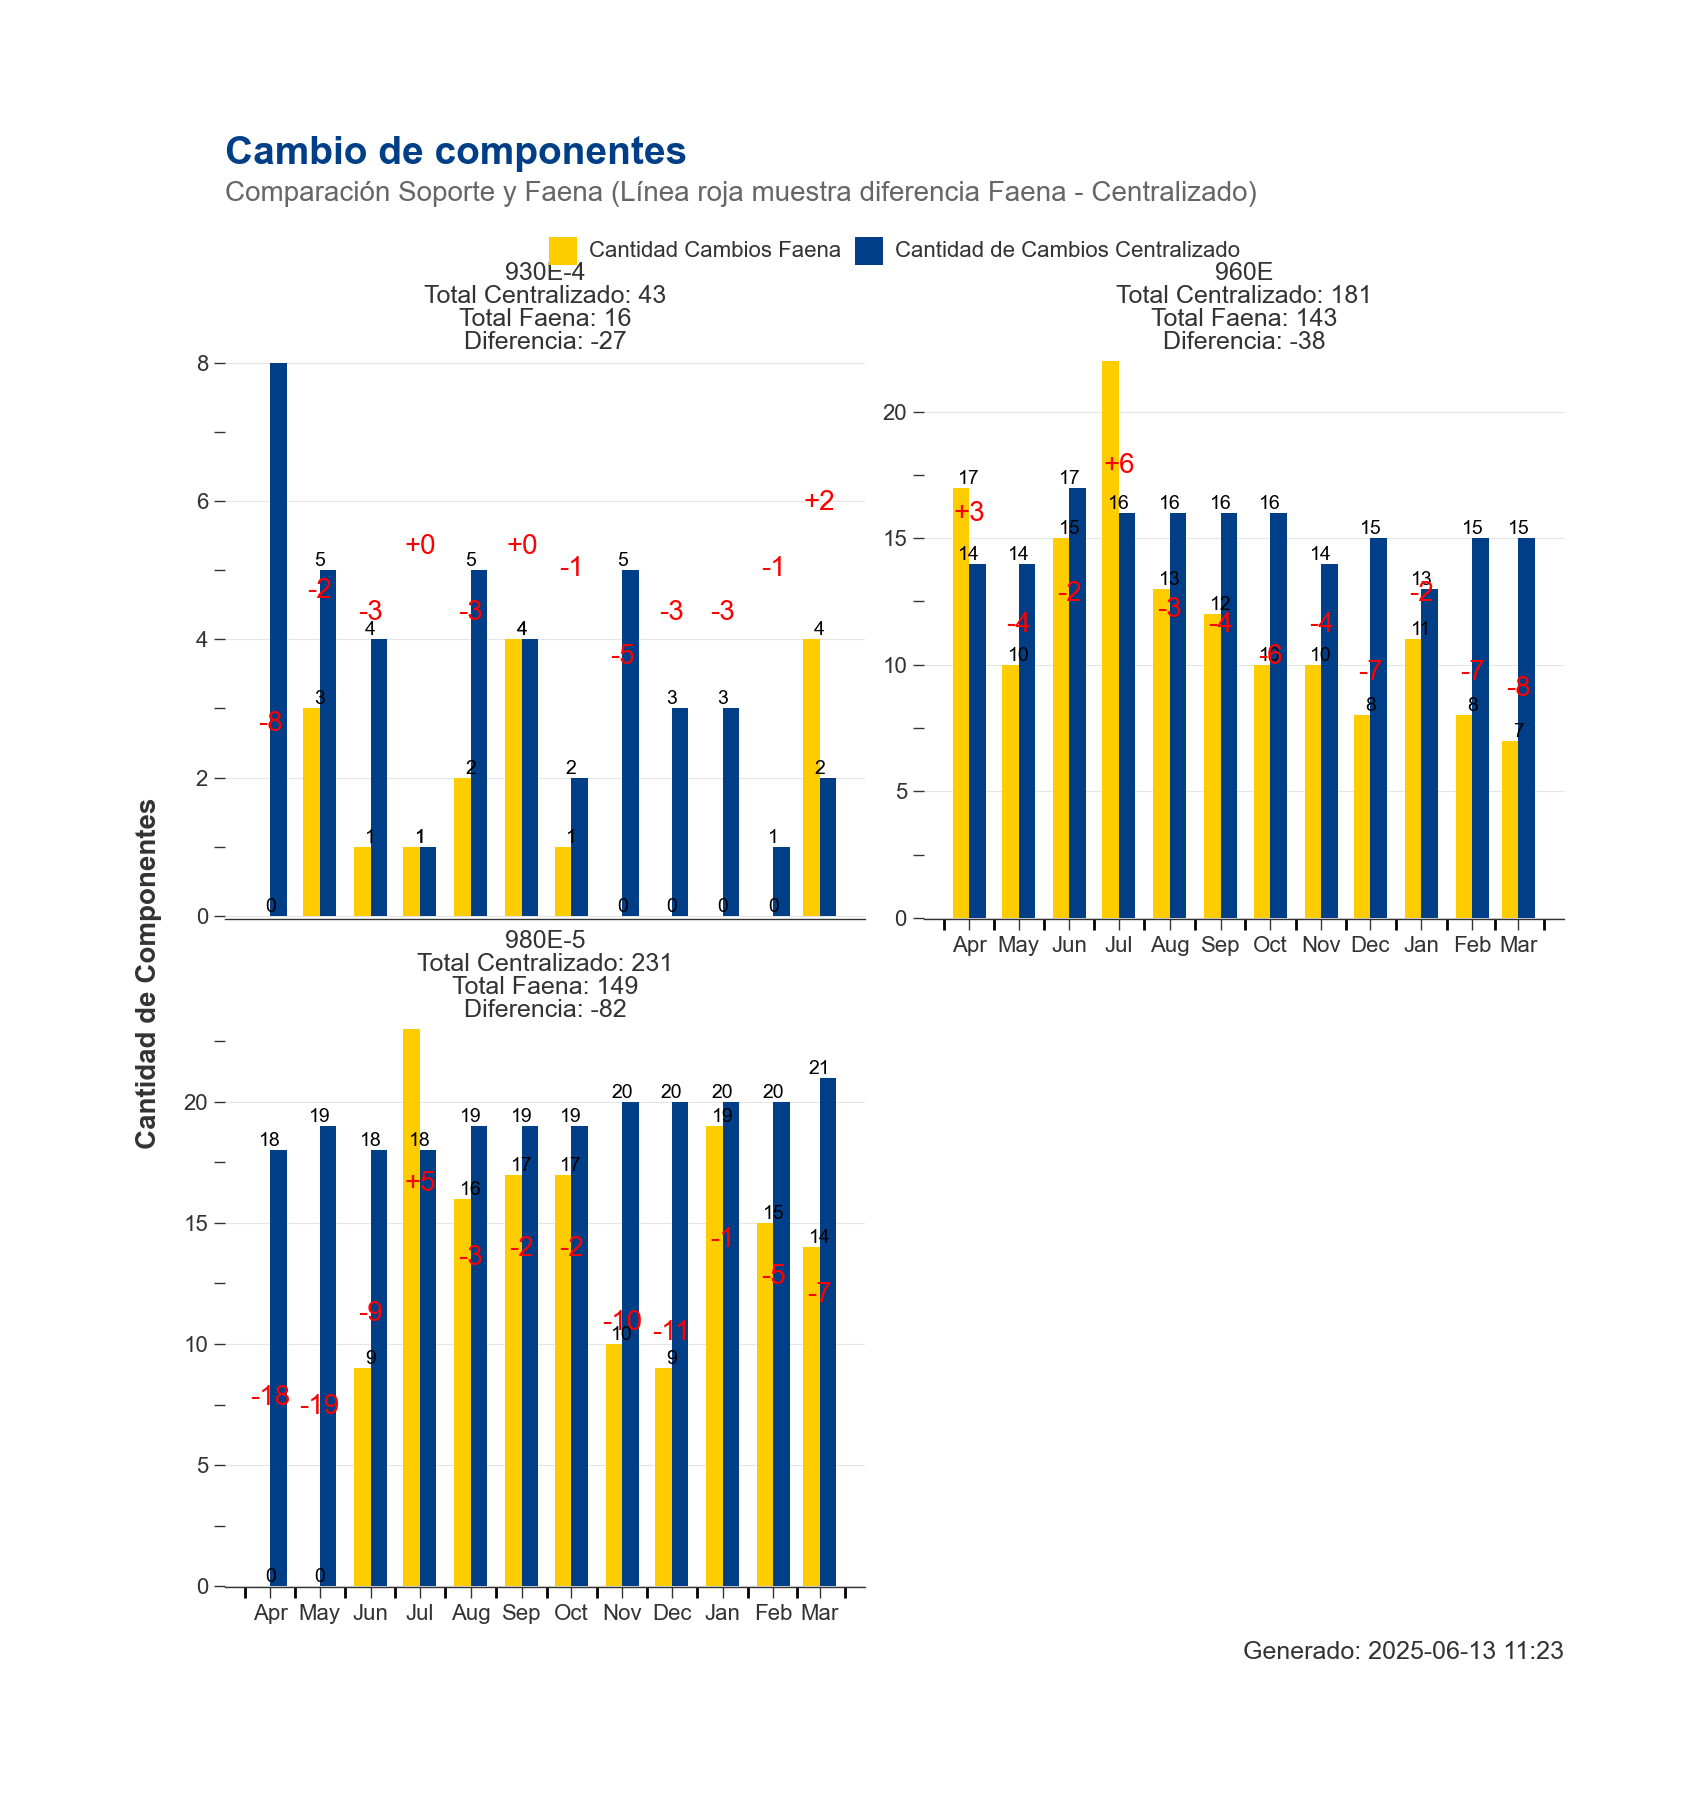

In [57]:
def prepare_monthly_data(
    df, group_cols=["site_name", "month_date"], include_difference=False
):
    """
    Prepare data for monthly aggregation

    Args:
        df: Polars DataFrame
        group_cols: List of columns to group by
        include_difference: Whether to include difference calculation

    Returns:
        Tuple of (melted_df, diff_df) if include_difference=True, else just melted_df
    """
    # Aggregate the data
    agg_df = (
        df.group_by(group_cols)
        .agg(
            [
                pl.col("proj_cc_amount").sum().alias("proj_cc_total"),
                pl.col("cc_amount").sum().alias("cc_total"),
            ]
        )
        .sort(group_cols)
    )

    # Calculate difference if needed
    if include_difference:
        diff_df = agg_df.with_columns(
            (pl.col("cc_total") - pl.col("proj_cc_total")).alias("difference")
        )

    # Melt the data for grouped bar plot
    melted_df = agg_df.melt(
        id_vars=group_cols,
        value_vars=["proj_cc_total", "cc_total"],
        variable_name="metric",
        value_name="count",
    )

    # Clean up metric names for display
    melted_df = melted_df.with_columns(
        pl.when(pl.col("metric") == "proj_cc_total")
        .then(pl.lit("Cantidad de Cambios Centralizado"))
        .when(pl.col("metric") == "cc_total")
        .then(pl.lit("Cantidad Cambios Faena"))
        .otherwise(pl.col("metric"))
        .alias("metric_label")
    )

    if include_difference:
        return melted_df, diff_df
    return melted_df


def create_monthly_grouped_bars_with_difference(
    df, title="", subtitle="", figure_size=(8.5, 9)
):
    """
    Create grouped bar plot with difference line on simulated secondary axis

    Args:
        df: Polars DataFrame (original, not melted)
        title: Plot title
        subtitle: Plot subtitle
        figure_size: Tuple of (width, height)

    Returns:
        plotnine plot object
    """
    # Prepare data with difference
    group_cols = ["site_name", "model_name", "month_date"]

    # Get melted data and difference data
    melted_df, diff_df = prepare_monthly_data(
        df, group_cols=group_cols, include_difference=True
    )

    # Convert to pandas
    pandas_melted = melted_df.to_pandas()
    pandas_diff = diff_df.to_pandas()

    # Calculate totals per model for the facet labels
    model_totals = (
        pandas_diff.groupby("model_name")
        .agg({"proj_cc_total": "sum", "cc_total": "sum", "difference": "sum"})
        .reset_index()
    )

    # Create custom facet labels with totals
    facet_labels = {}
    for _, row in model_totals.iterrows():
        model = row["model_name"]
        total_centralizado = int(row["proj_cc_total"])
        total_faena = int(row["cc_total"])
        total_diff = int(row["difference"])

        # Create multiline label
        facet_labels[model] = (
            f"{model}\n"
            f"Total Centralizado: {total_centralizado}\n"
            f"Total Faena: {total_faena}\n"
            f"Diferencia: {total_diff:+d}"
        )

    # Calculate scaling for each facet (model)
    models = pandas_diff["model_name"].unique()

    # Create a list to store all scaled data
    scaled_diffs = []

    for model in models:
        # Get data for this model
        model_melted = pandas_melted[pandas_melted["model_name"] == model]
        model_diff = pandas_diff[pandas_diff["model_name"] == model].copy()

        # Calculate scaling for this model
        max_count = model_melted["count"].max()
        if pd.isna(max_count) or max_count == 0:
            max_count = 1

        min_diff = model_diff["difference"].min()
        max_diff = model_diff["difference"].max()

        # Handle case where all differences are the same
        diff_range = max_diff - min_diff
        if diff_range == 0:
            diff_range = 1

        # Scale to use upper 40% of the plot
        scale_factor = (max_count * 0.4) / diff_range
        # Position zero at 60% height
        offset = max_count * 0.6

        # Add scaled values
        model_diff["scaled_difference"] = (
            model_diff["difference"] * scale_factor
        ) + offset
        model_diff["max_count"] = max_count

        scaled_diffs.append(model_diff)

    # Combine all scaled data
    pandas_diff_scaled = pd.concat(scaled_diffs, ignore_index=True)

    # Create the plot
    plot = (
        p9.ggplot(pandas_melted, p9.aes(x="month_date"))
        # Bar plot
        + p9.geom_col(
            p9.aes(y="count", fill="metric_label"), position="dodge", width=20
        )
        # Add value labels on bars
        + p9.geom_text(
            p9.aes(y="count", label="count"),
            position=p9.position_dodge(width=20),
            va="bottom",
            size=7,
            format_string="{:.0f}",
        )
        # Add scaled difference line
        # + p9.geom_line(
        #     p9.aes(x="month_date", y="scaled_difference", group="model_name"),
        #     data=pandas_diff_scaled,
        #     color="#FF0000",
        #     size=2,
        #     inherit_aes=False,
        # )
        # + p9.geom_point(
        #     p9.aes(x="month_date", y="scaled_difference"),
        #     data=pandas_diff_scaled,
        #     color="#FF0000",
        #     size=3,
        #     inherit_aes=False,
        # )
        # Add difference labels (showing actual values, not scaled)
        + p9.geom_text(
            p9.aes(x="month_date", y="scaled_difference", label="difference"),
            data=pandas_diff_scaled,
            color="#FF0000",
            va="bottom",
            size=10,
            format_string="{:+.0f}",
            inherit_aes=False,
            nudge_y=pandas_diff_scaled["max_count"].mean() * 0.02,
        )
        # Facet by model with custom labels
        + p9.facet_wrap(
            "~model_name", scales="free_y", ncol=2, labeller=lambda x: facet_labels[x]
        )
        # Color scale
        + p9.scale_fill_manual(
            values={
                "Cantidad de Cambios Centralizado": KOMATSU_COLORS["primary_blue"],
                "Cantidad Cambios Faena": KOMATSU_COLORS["primary_yellow"],
            },
            name="",
        )
        # X-axis formatting
        + p9.scale_x_date(date_labels="%b", date_breaks="1 month")
        # Y-axis formatting
        + p9.scale_y_continuous(
            expand=(0, 0.05), labels=lambda l: [f"{int(v)}" for v in l]
        )
        # Labels
        + p9.labs(
            title=title,
            subtitle=subtitle + " (Línea roja muestra diferencia Faena - Centralizado)",
            x="",
            y="Cantidad de Componentes",
            caption=f'Generado: {datetime.now().strftime("%Y-%m-%d %H:%M")}',
        )
        + theme_komatsu(figure_size=figure_size)
    )

    return plot


# 1. Create overall monthly plot with difference line
overall_plot_with_diff = create_monthly_grouped_bars_with_difference(
    monthly_df,
    title="Cambio de componentes",
    subtitle="Comparación Soporte y Faena",
)
overall_plot_with_diff

### Spence

In [20]:
GT(
    msgraph.read_tibble("sp://KCHCLGR00058/___/PAM/cambios_componentes_980E_faena.xlsx")
).tab_header(
    title="Cambios componente Faena",
    subtitle="Información con riesgo de pérdida al efectuar traspaso manual de información",
)

component_name,2025-04-01,2025-05-01,2025-06-01,2025-07-01,2025-08-01,2025-09-01,2025-10-01,2025-11-01,2025-12-01,2026-01-01,2026-02-01,2026-03-01
suspension_trasera,0,0,2,3,2,2,2,1,2,4,2,3
cilindro_levante,0,0,0,3,3,3,3,1,0,2,0,0
motor_traccion,0,0,1,3,3,2,3,2,3,4,3,4
cilindro_direccion,0,0,2,3,2,3,1,1,1,2,4,2
conjunto_maza_suspension,0,0,1,4,2,3,4,2,2,4,3,2
modulo_potencia,0,0,1,2,1,1,1,1,1,0,0,0
blower_parrilla,0,0,2,5,3,3,3,2,0,3,3,3


In [21]:
GT(
    msgraph.read_tibble(
        "sp://KCHCLGR00058/___/PAM/cambios_componentes_980E_soporte.xlsx"
    )
).tab_header(
    title="Cambios componente dictados por soporte",
    subtitle="Información con riesgo de pérdida al efectuar traspaso manual de información",
)

GT(_tbl_data=shape: (7, 19)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ component ┆ 2025-04-0 ┆ 2025-05-0 ┆ 2025-06-0 ┆ … ┆ Costo     ┆ Costo Pla ┆ Costo Imp ┆ Costo    │
│ _name     ┆ 1         ┆ 1         ┆ 1         ┆   ┆ Medio Rep ┆ nificado  ┆ revisto   ┆ PAM      │
│ ---       ┆ ---       ┆ ---       ┆ ---       ┆   ┆ aración   ┆ ---       ┆ ---       ┆ ---      │
│ str       ┆ i64       ┆ i64       ┆ i64       ┆   ┆ ---       ┆ f64       ┆ f64       ┆ i64      │
│           ┆           ┆           ┆           ┆   ┆ f64       ┆           ┆           ┆          │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ suspensio ┆ 2         ┆ 2         ┆ 2         ┆ … ┆ 27856.233 ┆ 668549.60 ┆ 111424.93 ┆ 584976   │
│ n_trasera ┆           ┆           ┆           ┆   ┆ 574       ┆ 5776      ┆ 4296      ┆          │
│ cilindro_ ┆ 4         ┆ 4         ┆ 4         ┆ … ┆ 28647.63  ┆ 1.3751e6  ┆ 114590.52 ┆ 1117261  │
│ levante   ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ motor_tra ┆ 2         ┆ 2         ┆ 3         ┆ … ┆ 347217.52 ┆ 1.0069e7  ┆ 1.3889e6  ┆ 8680440  │
│ ccion     ┆           ┆           ┆           ┆   ┆ 1763      ┆           ┆           ┆          │
│ cilindro_ ┆ 4         ┆ 4         ┆ 4         ┆ … ┆ 10255.41  ┆ 512770.5  ┆ 0.0       ┆ 0        │
│ direccion ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ conjunto_ ┆ 2         ┆ 3         ┆ 2         ┆ … ┆ 156613.84 ┆ 5.0116e6  ┆ 626455.36 ┆ 3602122  │
│ maza_susp ┆           ┆           ┆           ┆   ┆ 0999      ┆           ┆ 3996      ┆          │
│ ension    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ modulo_po ┆ 1         ┆ 1         ┆ 1         ┆ … ┆ 172363.95 ┆ 2.5855e6  ┆ 344727.9  ┆ 2413096  │
│ tencia    ┆           ┆           ┆           ┆   ┆           ┆           ┆           ┆          │
│ blower_pa ┆ 3         ┆ 3         ┆ 2         ┆ … ┆ 28011.636 ┆ 924383.99 ┆ 168069.81 ┆ 840349   │
│ rrilla    ┆           ┆           ┆           ┆   ┆ 35        ┆ 955       ┆ 81        ┆          │
└───────────┴───────────┴───────────┴───────────┴───┴───────────┴───────────┴───────────┴──────────┘, _body=<great_tables._gt_data.Body object at 0x000001F5D16E5E50>, _boxhead=Boxhead([ColInfo(var='component_name', type=<ColInfoTypeEnum.default: 1>, column_label='component_name', column_align='left', column_width=None), ColInfo(var='2025-04-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-04-01', column_align='right', column_width=None), ColInfo(var='2025-05-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-05-01', column_align='right', column_width=None), ColInfo(var='2025-06-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-06-01', column_align='right', column_width=None), ColInfo(var='2025-07-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-07-01', column_align='right', column_width=None), ColInfo(var='2025-08-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-08-01', column_align='right', column_width=None), ColInfo(var='2025-09-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-09-01', column_align='right', column_width=None), ColInfo(var='2025-10-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-10-01', column_align='right', column_width=None), ColInfo(var='2025-11-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-11-01', column_align='right', column_width=None), ColInfo(var='2025-12-01', type=<ColInfoTypeEnum.default: 1>, column_label='2025-12-01', column_align='right', column_width=None), ColInfo(var='2026-01-01', type=<ColInfoTypeEnum.default: 1>, column_label='2026-01-01', column_align='right', column_width=None), ColInfo(var='2026-02-01', type=<ColInfoTypeEnum.default: 1>, column_label='2026-02-01', column_align='right', column_width=None)

## Análisis del PAM

## Diferencia entre costo proyectado PAM y costo medio

In [32]:
diff_df = pam_df.with_columns(
    delta_cost=(
        pl.col("pam_repair_cost")
        - (pl.col("mean_repair_cost") * pl.col("proj_cc_amount"))
    ).round(0)
).filter(
    abs(pl.col("delta_cost")) >= 500
)  # .write_excel("diferencia_costos.xlsx")
msgraph.upload_tibble(diff_df, "sp://KCHCLGR00058/___/PAM/diferencia_costos_pam.xlsx")

GT(
    diff_df.group_by(["site_name", "component_name"]).agg(
        [
            pl.col("delta_cost").sum().alias("total_delta_cost"),
            pl.col("delta_cost").count().alias("record_count"),
        ]
    )
).tab_options(table_font_size="footnotesize", container_width="100%")

2025-06-12 23:52:49 -0400 - dagster - INFO - system - Writing 407 rows, 21 columns to sp://KCHCLGR00058/___/PAM/diferencia_costos_pam.xlsx


Note: Could not delete existing file 'sp://KCHCLGR00058/___/PAM/diferencia_costos_pam.xlsx' before upload (may not exist): ('itemNotFound', 'The resource could not be found.', '404 Client Error: Not Found for url: https://graph.microsoft.com/v1.0/sites/globalkomatsu.sharepoint.com,c7f58a9d-5684-4422-888c-bd43fce6b2d8,3053cef9-35cf-439f-8689-6b10af8dd53c/drive/root:/___/PAM/diferencia_costos_pam.xlsx:/')


site_name,component_name,total_delta_cost,record_count
SPENCE,modulo_potencia,1861124.0,31
MEL,suspension_trasera,-171066.0,6
SPENCE,motor_traccion,2592650.0,85
SPENCE,blower_parrilla,-84036.0,3
SPENCE,cilindro_direccion,-92295.0,9
MEL,cilindro_levante,-491852.0,18
SPENCE,conjunto_maza_suspension,2816563.0,59
MEL,motor_traccion,2219158.0,82
MEL,blower_parrilla,-28012.0,1
MEL,modulo_potencia,1513434.0,31


* **Causa común**: Todas las filas traen `pam_repair_cost = 0`; el hueco proviene de costos aún no imputados en PAM, no de un benchmark incorrecto.
* Existe consistencia en el cálculo del PAM, el PAM muestra el costo medio de reparación


## Análisis de Venta

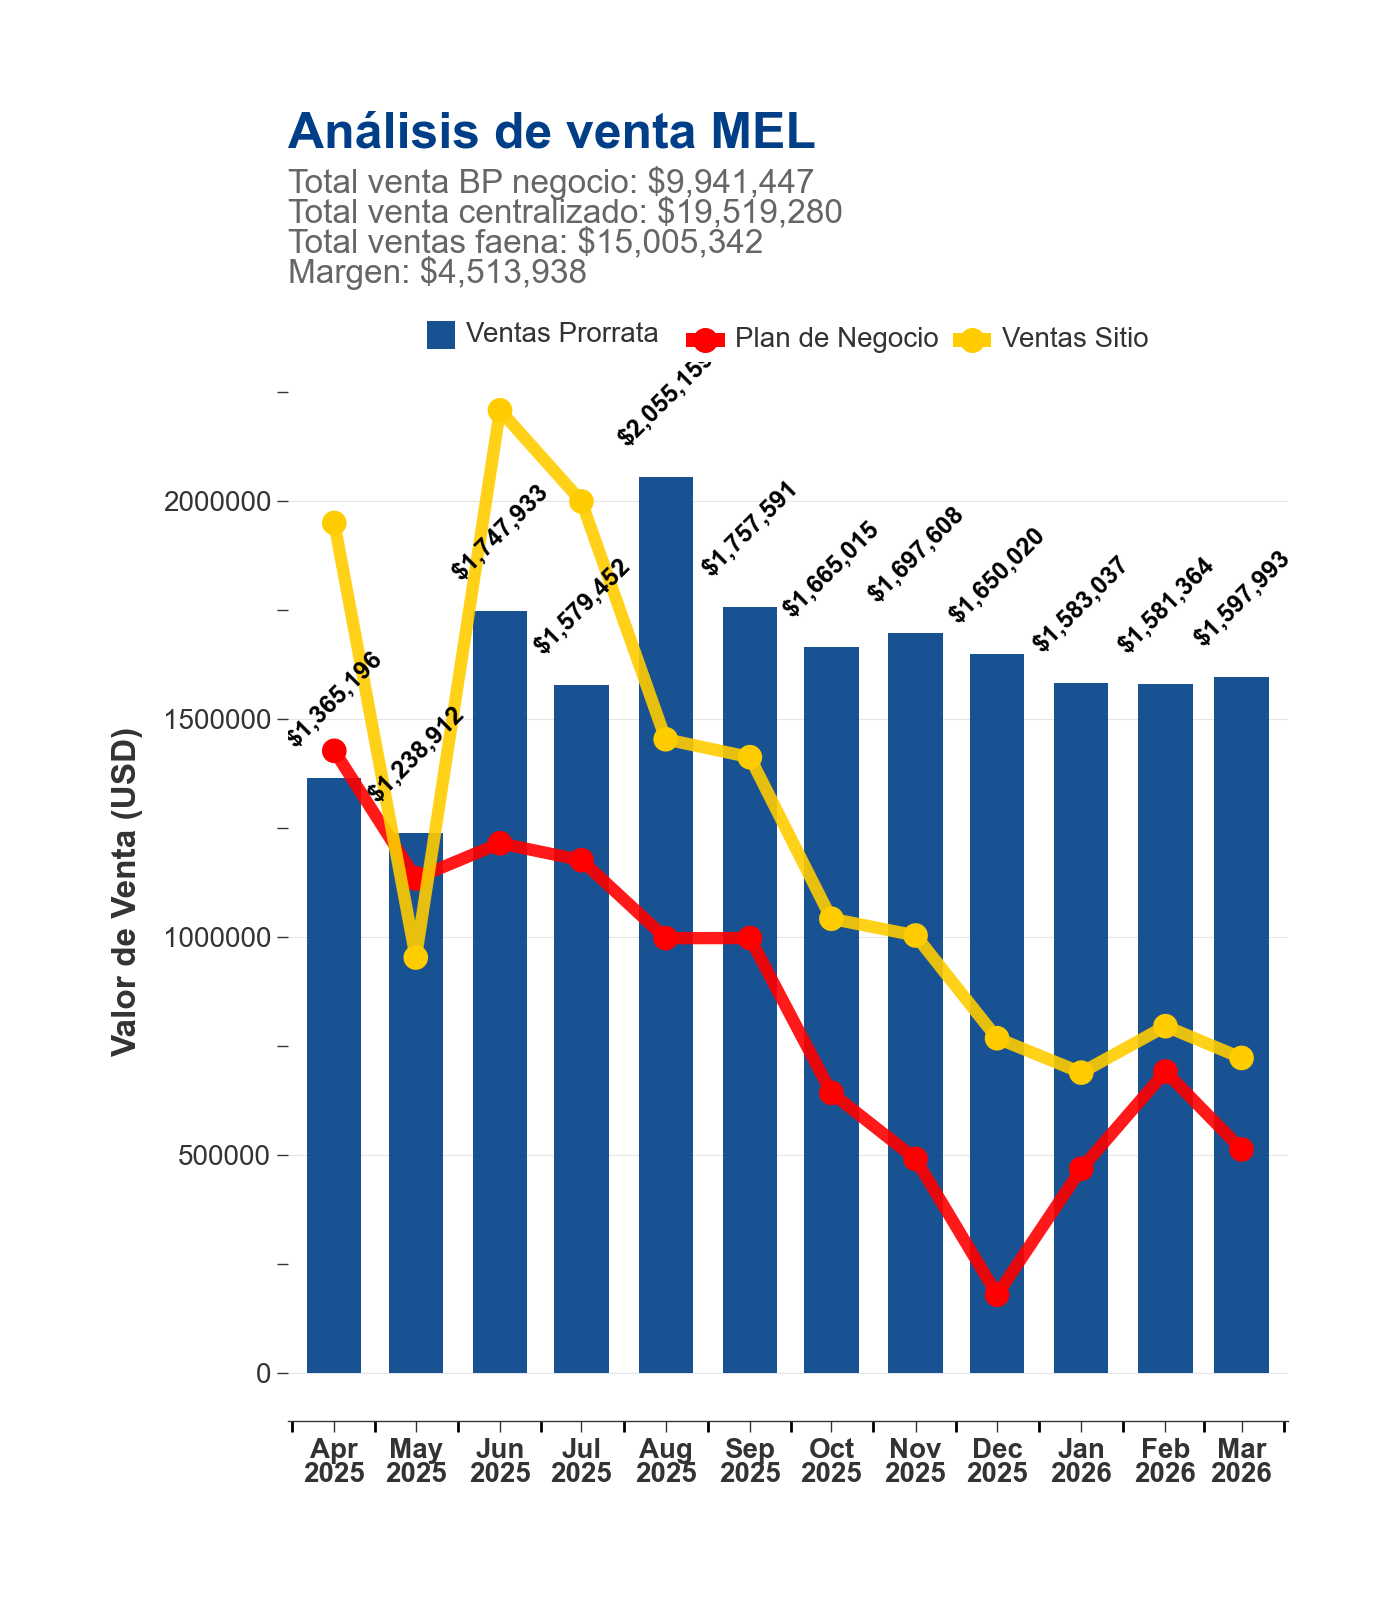

In [52]:
def plot_venta(df, site_name):
    # Calculate percentage of site_sale vs bp_sale
    pandas_df = df.clone().filter(pl.col("site_name") == site_name).to_pandas()

    # Calculate totals for subtitle
    total_bp = pandas_df["bp_sale"].sum()
    total_prorrata = pandas_df["prorrata_sale"].sum()
    total_site = pandas_df["site_sale"].sum()
    margen = total_prorrata - total_site

    # Format the subtitle with the totals
    subtitle_text = (
        f"Total venta BP negocio: ${total_bp:,.0f} \n"
        f"Total venta centralizado: ${total_prorrata:,.0f}\n"
        f"Total ventas faena: ${total_site:,.0f} \n"
        f"Margen: ${margen:,.0f}"
    )

    # Create the enhanced plot
    plot = (
        p9.ggplot(pandas_df, p9.aes(x="month_date"))
        # Bar plot for prorrata_sale
        + p9.geom_col(
            p9.aes(y="prorrata_sale", fill='"Ventas Prorrata"'),
            width=20,  # Slightly wider bars
            alpha=0.9,
        )
        # Line plot for bp_sale (red)
        + p9.geom_line(
            p9.aes(y="bp_sale", color='"Plan de Negocio"'), size=2.5, alpha=0.9
        )
        + p9.geom_point(
            p9.aes(y="bp_sale", color='"Plan de Negocio"'), size=4, shape="o"
        )
        # Line plot for site_sale (yellow)
        + p9.geom_line(
            p9.aes(y="site_sale", color='"Ventas Sitio"'), size=2.5, alpha=0.9
        )
        + p9.geom_point(
            p9.aes(y="site_sale", color='"Ventas Sitio"'), size=4, shape="o"
        )
        # Add value labels on bars
        + p9.geom_text(
            p9.aes(y="prorrata_sale", label="prorrata_sale"),
            va="bottom",
            size=9,  # Larger text
            format_string="${:,.0f}",
            nudge_y=60000,
            fontweight="bold",  # Bold text like original
            angle=45,
        )
        # Color and fill scales
        + p9.scale_fill_manual(
            values={"Ventas Prorrata": KOMATSU_COLORS["primary_blue"]}, name=""
        )
        + p9.scale_color_manual(
            values={
                "Plan de Negocio": "#FF0000",  # Red
                "Ventas Sitio": KOMATSU_COLORS["primary_yellow"],  # Yellow
            },
            name="",
        )
        # X-axis formatting with years
        + p9.scale_x_date(
            date_labels="%b\n%Y",  # Month and year like original
            date_breaks="1 month",
            expand=(0.02, 0.02),
        )
        # # Y-axis formatting
        # + p9.scale_y_continuous(
        #     labels=lambda l: [
        #         f"${v/1000000:.1f}M" if v >= 1000000 else f"${v/1000:.0f}K" for v in l
        #     ],
        #     limits=(0, 2700000),  # Slightly higher limit
        #     breaks=[0, 500000, 1000000, 1500000, 2000000, 2500000],
        #     expand=(0, 0.02),
        # )
        # Labels
        + p9.labs(
            title=f"Análisis de venta {site_name}",
            subtitle=subtitle_text,
            x="",
            y="Valor de Venta (USD)",
            caption="",
        )
        + theme_komatsu(figure_size=(7, 8))  # Larger size like original
        # Override some theme elements for better appearance
        + p9.theme(
            plot_title=p9.element_text(
                size=18, weight="bold", color=KOMATSU_COLORS["primary_blue"]
            ),
            plot_subtitle=p9.element_text(
                size=12, color=KOMATSU_COLORS["text_secondary"]
            ),
            axis_text_x=p9.element_text(size=10, weight="bold"),
            axis_text_y=p9.element_text(size=10),
            axis_title_y=p9.element_text(size=12, weight="bold"),
            legend_text=p9.element_text(size=10),
        )
        # Legend guides
        + p9.guides(
            fill=p9.guide_legend(order=1, ncol=1),
            color=p9.guide_legend(order=2, ncol=2),
        )
    )
    return plot


plot_venta(site_monthly_df, "MEL")

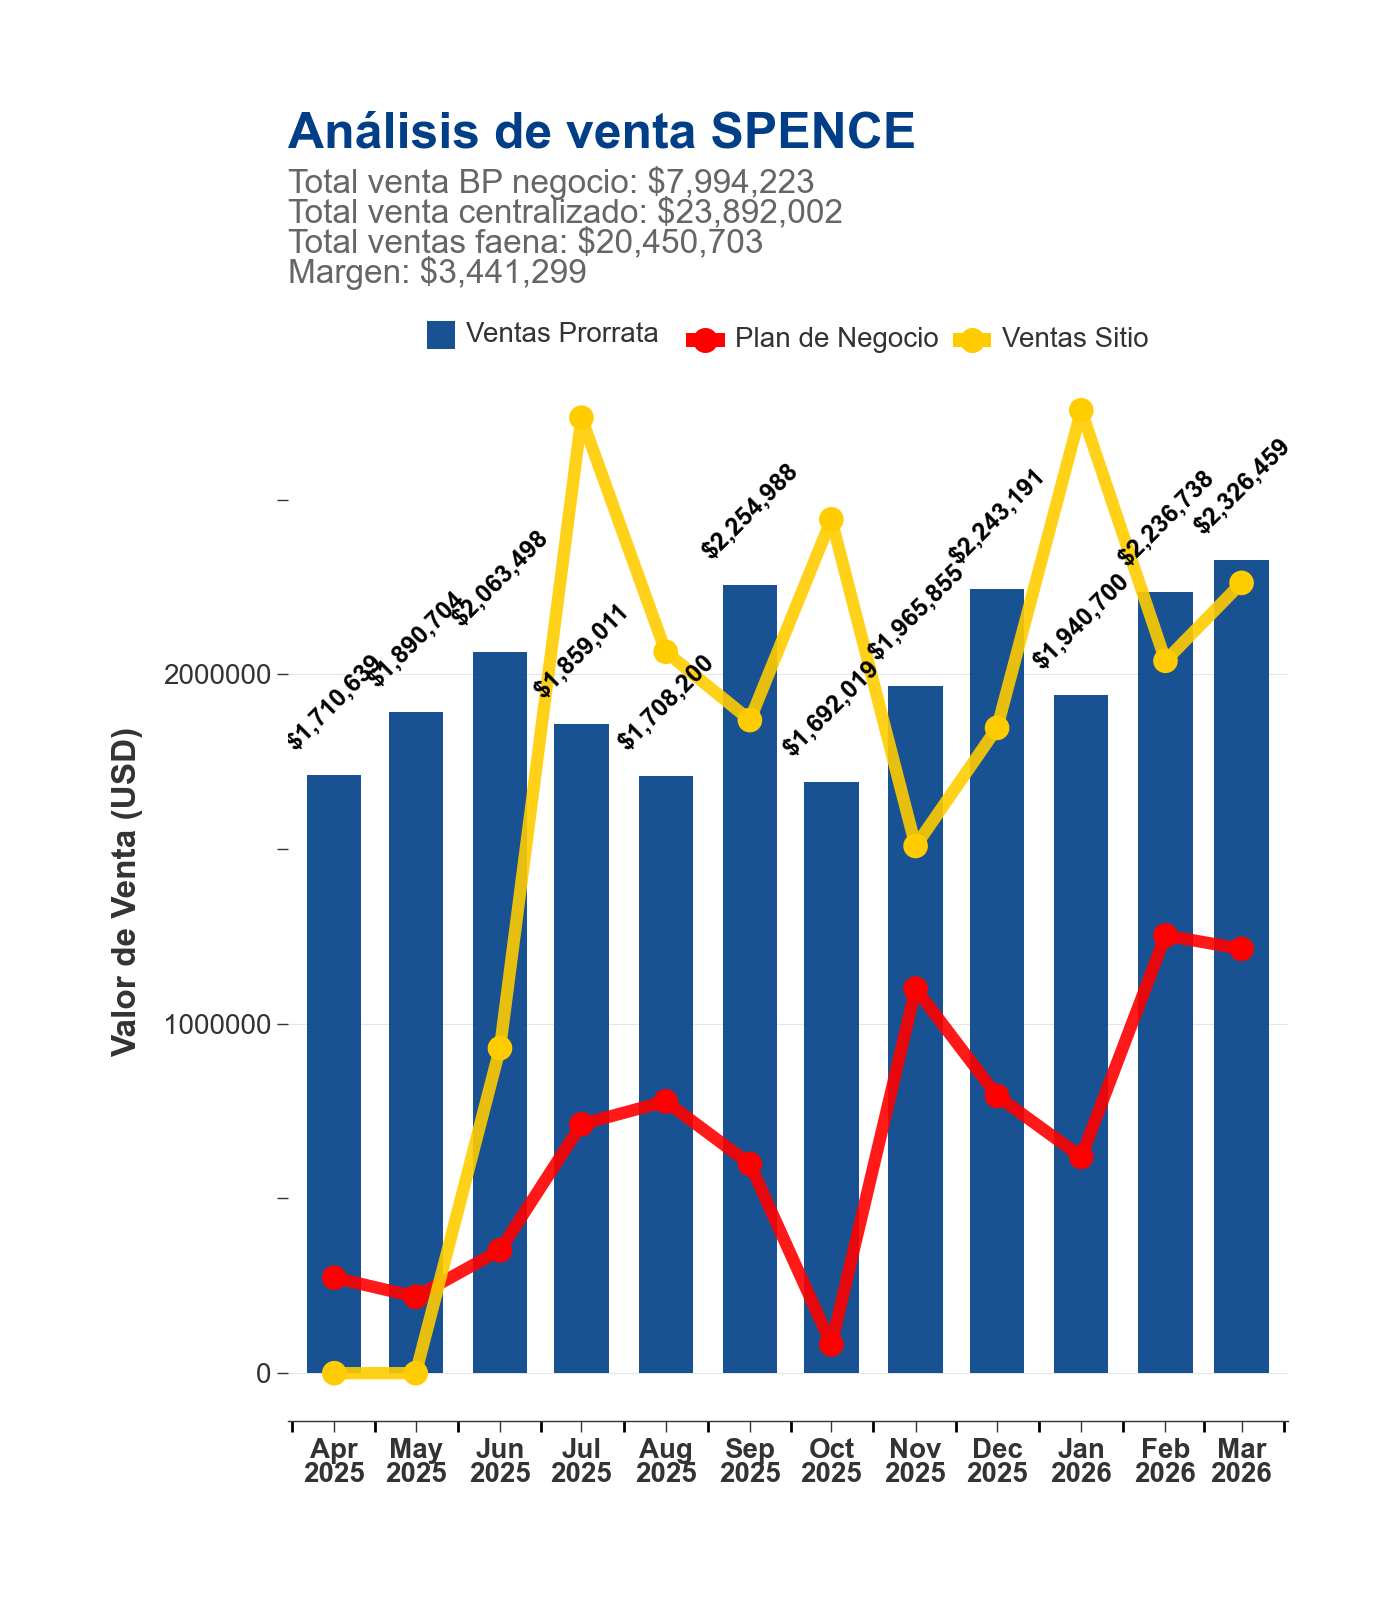

In [53]:
plot_venta(
    site_monthly_df.with_columns(site_sale=pl.col("site_sale").fill_null(0)), "SPENCE"
)

## Costos

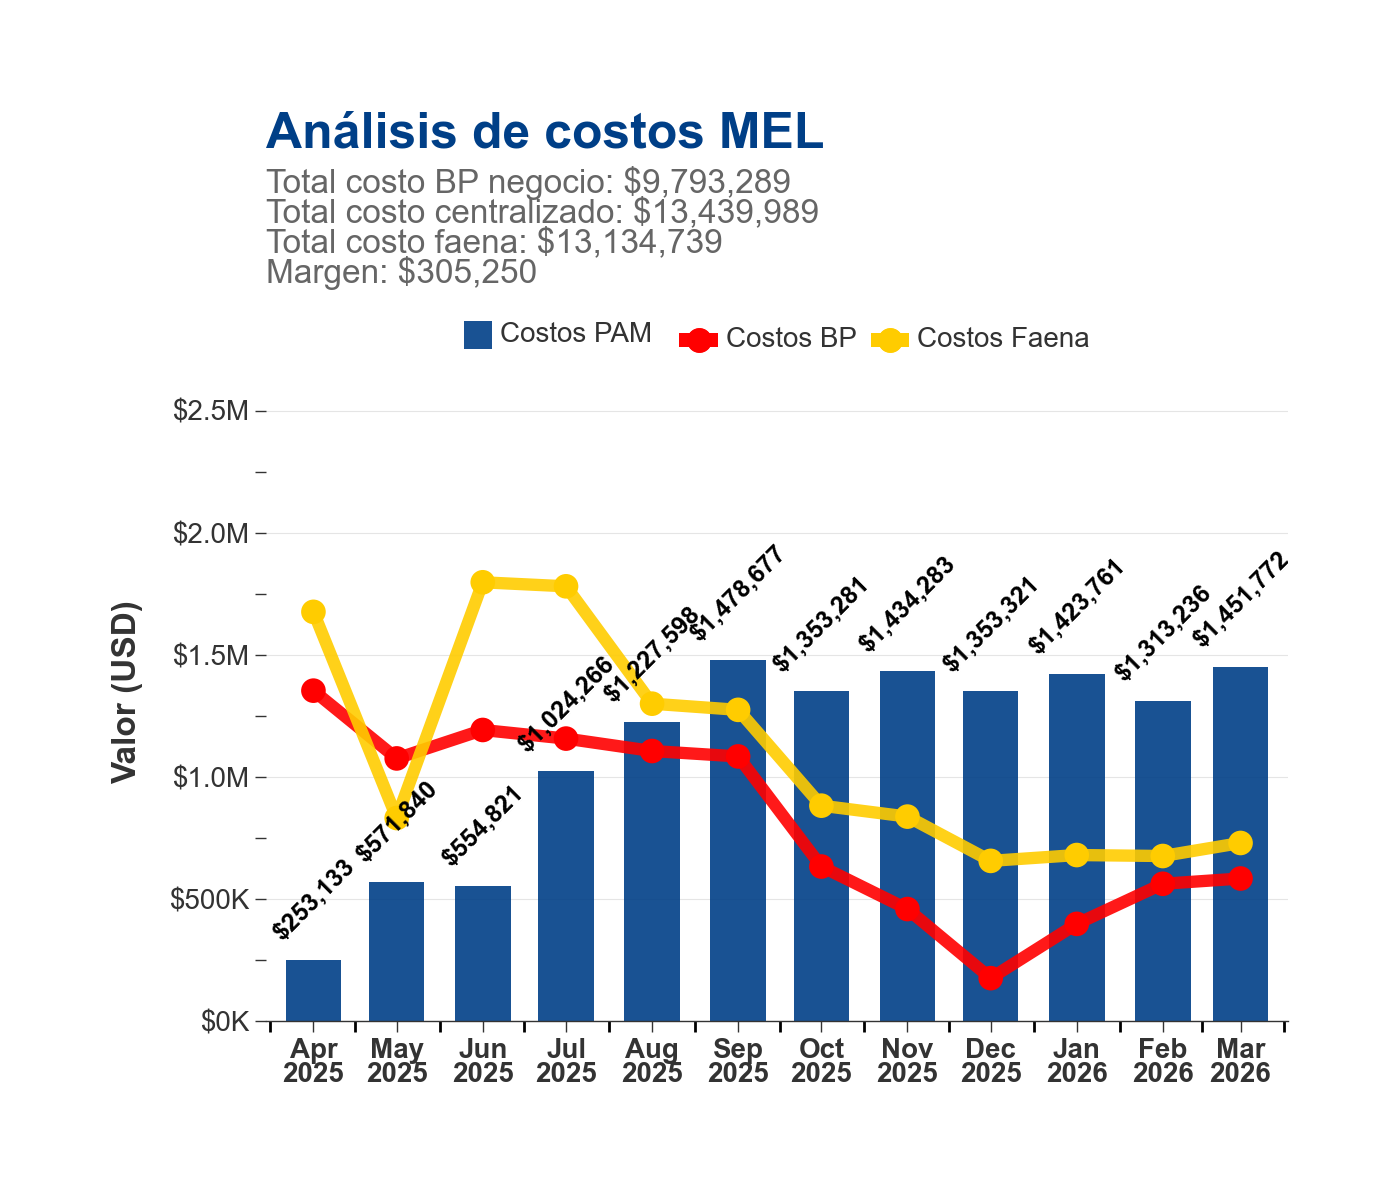

In [54]:
def plot_costos(df, site_name):
    # Calculate percentage of site_sale vs bp_sale
    pandas_df = df.clone().filter(pl.col("site_name") == site_name).to_pandas()

    # Calculate totals for subtitle
    total_bp = pandas_df["bp_repair_cost"].sum()
    costos_pam = pandas_df["pam_repair_cost"].sum()
    total_site = pandas_df["site_repair_cost"].sum()
    margen = costos_pam - total_site

    # Format the subtitle with the totals
    subtitle_text = (
        f"Total costo BP negocio: ${total_bp:,.0f} \n"
        f"Total costo centralizado: ${costos_pam:,.0f}\n"
        f"Total costo faena: ${total_site:,.0f} \n"
        f"Margen: ${margen:,.0f}"
    )

    # Create the enhanced plot
    plot = (
        p9.ggplot(pandas_df, p9.aes(x="month_date"))
        # Bar plot for prorrata_sale
        + p9.geom_col(
            p9.aes(y="pam_repair_cost", fill='"Costos PAM"'),
            width=20,  # Slightly wider bars
            alpha=0.9,
        )
        # Line plot for bp_sale (red)
        + p9.geom_line(
            p9.aes(y="bp_repair_cost", color='"Costos BP"'), size=2.5, alpha=0.9
        )
        + p9.geom_point(
            p9.aes(y="bp_repair_cost", color='"Costos BP"'), size=4, shape="o"
        )
        # Line plot for site_sale (yellow)
        + p9.geom_line(
            p9.aes(y="site_repair_cost", color='"Costos Faena"'), size=2.5, alpha=0.9
        )
        + p9.geom_point(
            p9.aes(y="site_repair_cost", color='"Costos Faena"'), size=4, shape="o"
        )
        # Add value labels on bars
        + p9.geom_text(
            p9.aes(y="pam_repair_cost", label="pam_repair_cost"),
            va="bottom",
            size=9,  # Larger text
            format_string="${:,.0f}",
            nudge_y=60000,
            fontweight="bold",  # Bold text like original
            angle=45,
        )
        # Color and fill scales
        + p9.scale_fill_manual(
            values={"Costos PAM": KOMATSU_COLORS["primary_blue"]}, name=""
        )
        + p9.scale_color_manual(
            values={
                "Costos BP": "#FF0000",  # Red
                "Costos Faena": KOMATSU_COLORS["primary_yellow"],  # Yellow
            },
            name="",
        )
        # X-axis formatting with years
        + p9.scale_x_date(
            date_labels="%b\n%Y",  # Month and year like original
            date_breaks="1 month",
            expand=(0.02, 0.02),
        )
        # Y-axis formatting
        + p9.scale_y_continuous(
            labels=lambda l: [
                f"${v/1000000:.1f}M" if v >= 1000000 else f"${v/1000:.0f}K" for v in l
            ],
            limits=(0, 2700000),  # Slightly higher limit
            breaks=[0, 500000, 1000000, 1500000, 2000000, 2500000],
            expand=(0, 0.02),
        )
        # Labels
        + p9.labs(
            title=f"Análisis de costos {site_name}",
            subtitle=subtitle_text,
            x="",
            y="Valor (USD)",
            caption="",
        )
        + theme_komatsu(figure_size=(7, 6))  # Larger size like original
        # Override some theme elements for better appearance
        + p9.theme(
            plot_title=p9.element_text(
                size=18, weight="bold", color=KOMATSU_COLORS["primary_blue"]
            ),
            plot_subtitle=p9.element_text(
                size=12, color=KOMATSU_COLORS["text_secondary"]
            ),
            axis_text_x=p9.element_text(size=10, weight="bold"),
            axis_text_y=p9.element_text(size=10),
            axis_title_y=p9.element_text(size=12, weight="bold"),
            legend_text=p9.element_text(size=10),
        )
        # Legend guides
        + p9.guides(
            fill=p9.guide_legend(order=1, ncol=1),
            color=p9.guide_legend(order=2, ncol=2),
        )
    )
    return plot


plot_costos(site_monthly_df, "MEL")

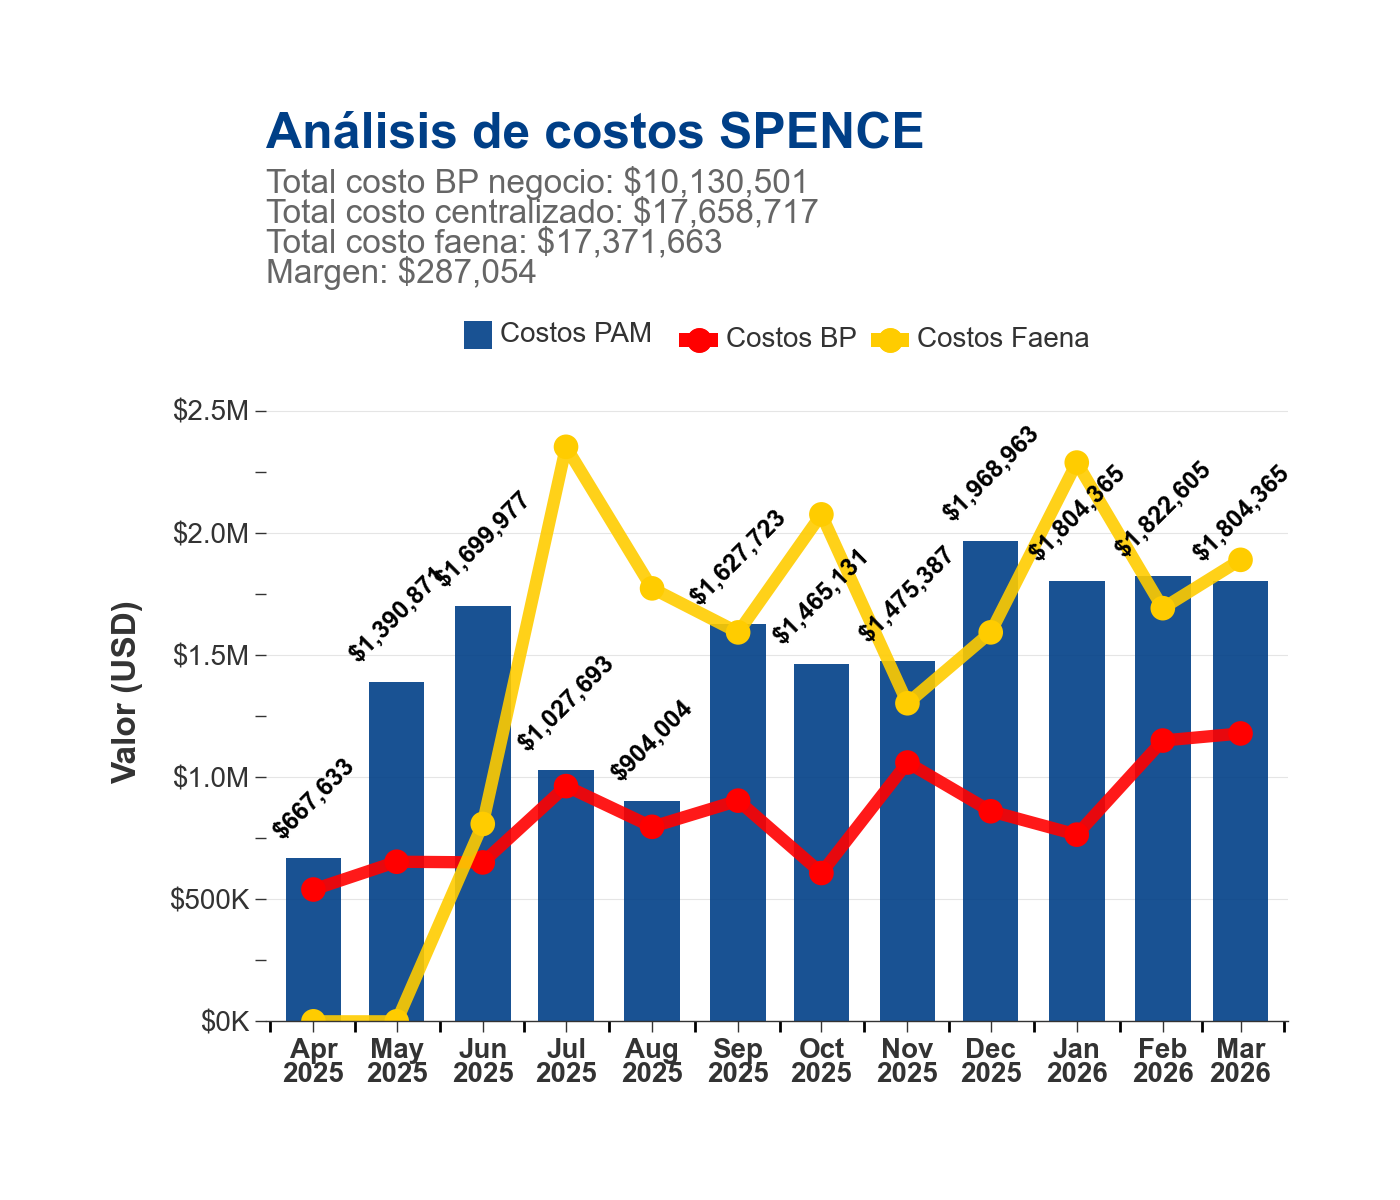

In [55]:
plot_costos(site_monthly_df, "SPENCE")